In [1]:
# Potato Disease Classification

In [2]:
# # Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
# # Set all the Constants

In [5]:
#creating some constants
BATCH_SIZE = 32 # most common batch size is 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [6]:
# Import data into tensorflow dataset object

In [7]:
#We will use image_dataset_from_directory api to load all images in tensorflow dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", # directory name
    seed=123,
    shuffle=True, # gives shuffled data
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # IMAGE_SIZE in my data is 256x256
    batch_size=BATCH_SIZE
)

# it loaded files belonging to 3 classes (ie, our 3 folders)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names # our folder names are our class names.
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset) # this is 68 because, every batch has 32 images and we have total 2176 images. So, 2176/32 = 68 batches

68

In [10]:
# this gives one batch of images and labels
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)# image_batch → a batch of input images
    print(labels_batch.numpy()) # labels_batch → the corresponding labels for those images, this converts the label tensor to a NumPy array so you can see the actual values.
# Each number corresponds to a class (e.g., 0 = cat, 1 = dog), This array has 32 values, one label for each image in the batch.
# 32 batches, each image is 256x256 with 3 channels(rgb)

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [11]:
# As you can see above, each element in the dataset is a tuple. 
# First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

In [12]:
# Visualize some of the images from our dataset

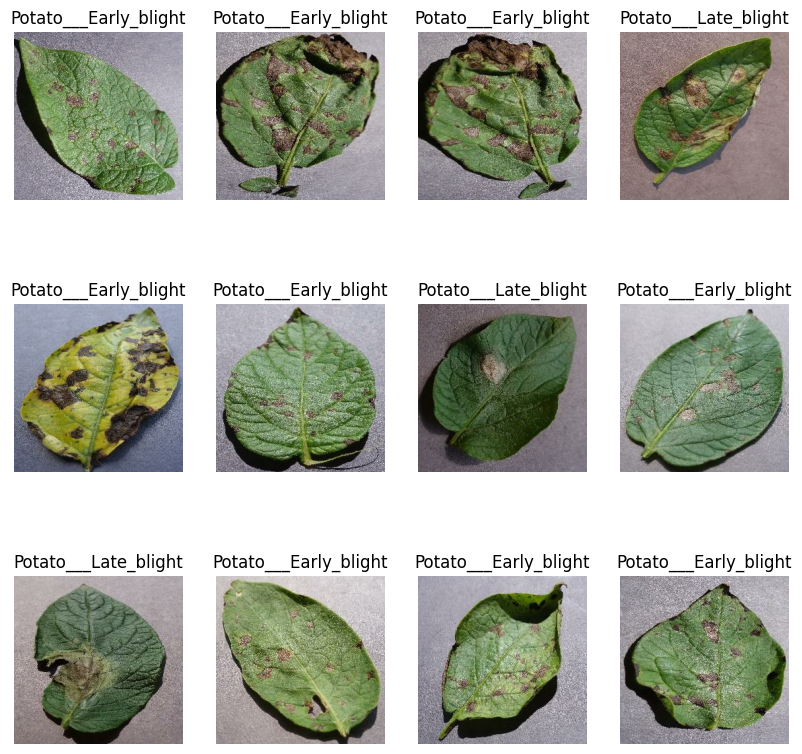

In [13]:
plt.figure(figsize=(10, 10)) # figure size of 10x10 inches (width x height)
for image_batch, labels_batch in dataset.take(1): # this gives one batch of images and labels
    for i in range(12): # im displaying 12 images from that batch (random images)
        ax = plt.subplot(3, 4, i + 1) # making a grid of 3 rows and 4 columns
        plt.imshow(image_batch[i].numpy().astype("uint8")) # this converts tensor to numpy array and then to uint8 format(basically gives images)
        plt.title(class_names[labels_batch[i]])# this labels_batch[i] will give numbers,so class_names[labels_batch[i]] will give folder names (class names)
        plt.axis("off")

In [14]:
'''Function to Split Dataset

Dataset should be divided into 3 subsets, namely:
1. Training: Dataset to be used while training (we use 80%)
2. Validation: Dataset to be tested against while training (we use 10%)
3. Test: Dataset to be tested against after we trained a model (we use 10%)

from 20% of the data, we will use 10% for validation after eavery epoch and 10% for testing after 50 epoch is finished.
'''

'Function to Split Dataset\n\nDataset should be divided into 3 subsets, namely:\n1. Training: Dataset to be used while training (we use 80%)\n2. Validation: Dataset to be tested against while training (we use 10%)\n3. Test: Dataset to be tested against after we trained a model (we use 10%)\n\nfrom 20% of the data, we will use 10% for validation after eavery epoch and 10% for testing after 50 epoch is finished.\n'

In [15]:
len(dataset)

68

In [16]:
train_size = 0.8
len(dataset)*train_size # i wanna use 54% for training out of 68 batches

54.400000000000006

In [17]:
train_ds = dataset.take(54) # this will take first 54 batches for training ( so , i took 80% of 68 batches for training)
len(train_ds)

54

In [18]:
test_ds = dataset.skip(54) # this will skip first 54 batches and will take remaining batches for testing, ie, 14 batches (20% of 68 batches).
len(test_ds)

14

In [19]:
val_size=0.1 # i wanna use 10% of test data for validation in each epoch
len(dataset)*val_size

6.800000000000001

In [20]:
val_ds = test_ds.take(6) # this will take 6 batches from test_ds for validation
len(val_ds)

6

In [21]:
test_ds = test_ds.skip(6) # this will skip first 6 batches from test_ds and will take remaining batches for testing
len(test_ds)

8

In [22]:
# Function to Split Dataset into Train, Validation and Test Sets
# we will use 80% data for training, 10% for validation and 10% for testing
# the above code is wrapped into a function below
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1 # making sure the splits add up to 1, ie, 100%
    
    ds_size = len(ds) # total number of batches in the dataset, ie, 68 in our case.
    
    if shuffle: # shuffling the dataset
        ds = ds.shuffle(shuffle_size, seed=12) # shuffle_size is buffer size, the larger the better shuffling (but more memory consumption).
    
    train_size = int(train_split * ds_size) # number of batches to be used for training, ie, 54 batches.(0.8 * 68 = 54.4)
    val_size = int(val_split * ds_size) # number of batches to be used for validation, ie, 6 batches.(0.1 * 68 = 6.8)
    
    train_ds = ds.take(train_size)    # first 54 batches for training(80%)
    val_ds = ds.skip(train_size).take(val_size)# next 6 batches for validation(10%)
    test_ds = ds.skip(train_size).skip(val_size)# remaining batches for testing(10%)
    
    return train_ds, val_ds, test_ds # returning the 3 datasets.

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset) # calling the function to get the 3 datasets

In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

8

In [27]:
# Cache, Shuffle, and Prefetch the Dataset

In [28]:
# this basically optimizes the performance of dataset during training by caching data in memory, shuffling it to ensure randomness, and prefetching to overlap data preparation and model execution.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
'''
.cache()
Stores the dataset (images) in memory (or on disk if a filename is provided).
After the first epoch, data is read from cache instead of reloading from source.

.shuffle(1000)
Randomly shuffles elements in the dataset, 1000 is the buffer size
Larger buffer → better randomness, more memory usage

.prefetch(buffer_size=tf.data.AUTOTUNE)
Loads the next batch while the model is training on the current batch
Enables parallelism between CPU (data loading) and GPU/TPU (training)


AUTOTUNE is a TensorFlow setting that automatically chooses the best performance-related parameter for you at runtime.
'''

'\n.cache()\nStores the dataset (images) in memory (or on disk if a filename is provided).\nAfter the first epoch, data is read from cache instead of reloading from source.\n\n.shuffle(1000)\nRandomly shuffles elements in the dataset, 1000 is the buffer size\nLarger buffer → better randomness, more memory usage\n\n.prefetch(buffer_size=tf.data.AUTOTUNE)\nLoads the next batch while the model is training on the current batch\nEnables parallelism between CPU (data loading) and GPU/TPU (training)\n\n\nAUTOTUNE is a TensorFlow setting that automatically chooses the best performance-related parameter for you at runtime.\n'

In [30]:
# # Building the Model

In [31]:
'''Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be 
useful when we are done with the training and start using the model for predictions. 
At that time somone can supply an image that is not (256,256) and this layer will resize it'''

"Creating a Layer for Resizing and Normalization\nBefore we feed our images to network, we should be resizing it to the desired size. \nMoreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).\nThis should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.\n\nYou might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be \nuseful when we are done with the training and start using the model for predictions. \nAt that time somone can supply an image that is not (256,256) and this layer will resize it"

In [32]:
# this scales pixel values to range 0-1 and resizes images to IMAGE_SIZE x IMAGE_SIZE
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), # our image already is of IMAGE_SIZE x IMAGE_SIZE but this will be useful during inference time if we supply any other size image. 
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [33]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [34]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flips images both horizontally and vertically
  layers.experimental.preprocessing.RandomRotation(0.2),# rotates the image by 20% of 2π radians (ie, 0.2 * 360 = 72 degrees)
])

In [35]:
## Applying Data Augmentation to Train Dataset

In [36]:
# this basically applies data augmentation only on training dataset
train_ds = train_ds.map( # this applies the function to each element in the dataset
    lambda x, y: (data_augmentation(x, training=True), y) # this applies data_augmentation only on images(x), not on labels(y)
).prefetch(buffer_size=tf.data.AUTOTUNE) # prefetching for performance



In [37]:
# Model Architecture using CNN
#We use a CNN coupled with a Softmax activation in the output layer. 
#We also add the initial layers for resizing, normalization and Data Augmentation.

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) # (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale, # resizing and rescaling layer by divided by 255
    data_augmentation, # data augmentation layer
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), # first conv layer with 32 filters of stride size 3x3, i choose 32 filters because as trial and error. 
    layers.MaxPooling2D((2, 2)), # max pooling layer with pool size of 2x2
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'), # second conv layer with 64 filters of size 3x3
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),# flattening the 3D feature maps to 1D feature vectors
    layers.Dense(64, activation='relu'), # fully connected layer with 64 neurons and relu activation
    layers.Dense(n_classes, activation='softmax'), # 3 output layers with softmax activation.
])

model.build(input_shape=input_shape) # building the model with input shape, model.build will take input as (batch_size, height, width, channels)

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [40]:
# Compiling the Model
# We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
# Training the Model
history = model.fit(
    train_ds, # training dataset
    batch_size=BATCH_SIZE, # batch size
    validation_data=val_ds, # validation dataset
    verbose=1, 
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 89s 2s/step - loss: 0.9191 - accuracy: 0.4763 - val_loss: 0.8749 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.7692 - accuracy: 0.6285 - val_loss: 1.2318 - val_accuracy: 0.5781
Epoch 3/50
54/54 [==============================] - 86s 2s/step - loss: 0.5466 - accuracy: 0.7818 - val_loss: 0.5804 - val_accuracy: 0.7083
Epoch 4/50
54/54 [==============================] - 91s 2s/step - loss: 0.4113 - accuracy: 0.8339 - val_loss: 1.4625 - val_accuracy: 0.6354
Epoch 5/50
54/54 [==============================] - 81s 1s/step - loss: 0.3343 - accuracy: 0.8692 - val_loss: 0.3932 - val_accuracy: 0.8281
Epoch 6/50
54/54 [==============================] - 70s 1s/step - loss: 0.3187 - accuracy: 0.8733 - val_loss: 0.3814 - val_accuracy: 0.8490
Epoch 7/50
54/54 [==============================] - 68s 1s/step - loss: 0.2337 - accuracy: 0.9039 - val_loss: 0.3575 - val_accuracy: 0.8854
Epoch 8/50
54/54 [==

In [43]:
# model.fit(..., verbose=0) Silent mode | No output is shown during training | Useful for scripts, automation, or when logging elsewhere
# verbose=1 | Progress bar mode | Shows output for every epoch | Displays: | Epoch number | Progress bar per epoch | Loss |Accuracy (and other metrics) | Validation loss & accuracy

In [44]:
scores = model.evaluate(test_ds) #evaluate() tells you how well the model performs; predict() tells you what the model predicts.

8/8 [==============================] - 3s 291ms/step - loss: 0.2021 - accuracy: 0.9453


In [45]:
# You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [46]:
scores

[0.20212770998477936, 0.9453125]

In [47]:
# Scores is just a list containing loss and accuracy value

In [48]:
# # Plotting the Accuracy and Loss Curves

In [49]:
history

In [50]:
history.params # this gives the parameters used during training, params is a dictionary containing details about the training process such as number of epochs, batch size, and number of steps per epoch.

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [51]:
'''
In Keras/TensorFlow:
When you call model.fit(...), it returns a History object.
example:
history = model.fit(train_ds, epochs=10)
print(history.history)  # dict of loss, accuracy per epoch

The .history attribute contains a dictionary of all metrics tracked during training, 
like loss, accuracy, val_loss, val_accuracy, etc. So here, .history is not on the model itself, 
but on the object returned by fit().
'''

'\nIn Keras/TensorFlow:\nWhen you call model.fit(...), it returns a History object.\nexample:\nhistory = model.fit(train_ds, epochs=10)\nprint(history.history)  # dict of loss, accuracy per epoch\n\nThe .history attribute contains a dictionary of all metrics tracked during training, \nlike loss, accuracy, val_loss, val_accuracy, etc. So here, .history is not on the model itself, \nbut on the object returned by fit().\n'

In [52]:
history.history.keys() # this gives all the metrics we recorded during training
# the first history is our trained dataset name and second history an atribute with which we can uses different keys.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
# loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [54]:
type(history.history['loss'])

list

In [55]:
len(history.history['loss'])

50

In [56]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9191222786903381,
 0.7691518068313599,
 0.5466031432151794,
 0.4112623333930969,
 0.3342668116092682]

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

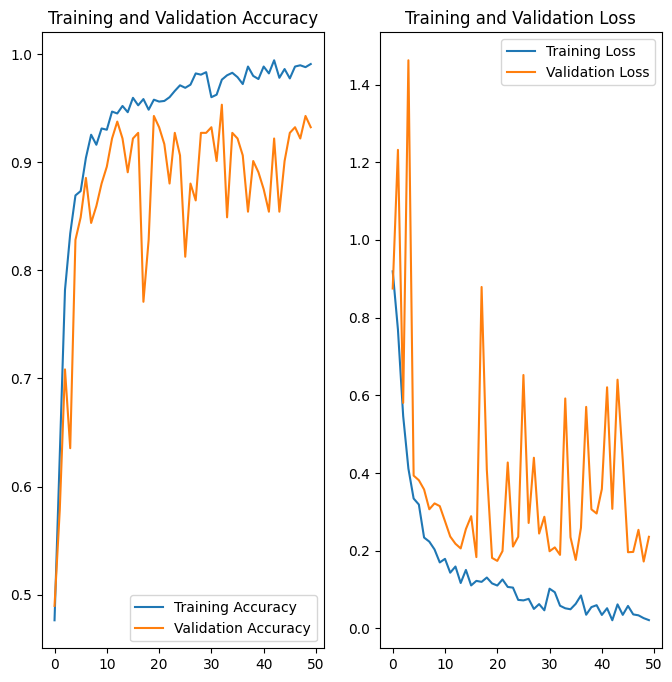

In [58]:
# Plotting the training and validation accuracy and loss curves
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) # plotting in 1 row and 2 columns, this is first plot
plt.plot(range(EPOCHS), acc, label='Training Accuracy') # plotting training accuracy
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy') # plotting validation accuracy
plt.legend(loc='lower right') # legend at lower right
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # this is second plot
plt.plot(range(EPOCHS), loss, label='Training Loss') 
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#see in graph accuracy is increasing and loss is decreasing which is a good sign

In [59]:
 # Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 521ms/step
predicted label: Potato___Late_blight


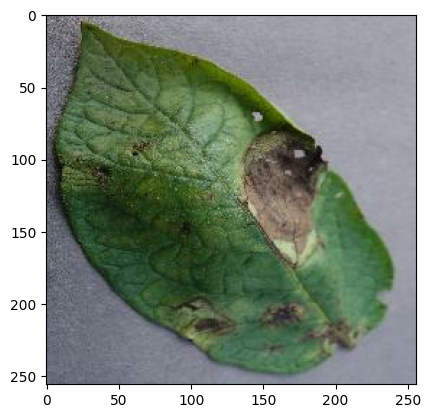

In [60]:
import numpy as np
# this function takes one batch from test dataset and predicts the label for first image in that batch
for images_batch, labels_batch in test_ds.take(1): # taking one batch from test dataset
    #take first image in the batch
    first_image = images_batch[0].numpy().astype('uint8') # converting tensor to numpy array and then to uint8 format to convert to image.
    first_label = labels_batch[0].numpy() #this gives the actual label of first image in the batch. eg, returns 0,1 or 2 for 3 classes.

    print("first image to predict")
    plt.imshow(first_image) # displaying the first image in the batch
    print("actual label:",class_names[first_label]) # printing the actual label of the first image, class_names is our folder names., first_label returns 0,1 or 2 for 3 classes (this depends on whuch class this image belongs to)
    
    batch_prediction = model.predict(images_batch) # predicting the labels for the entire batch
    # the above line returns a array where each row corresponds to the predicted probabilities for each class for that image in the batch, from that we take the maximum probability class for first image in the batch, ie np.argmax(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) # printing the predicted label for first image in the batch, [np.argmax(batch_prediction[0])] returns the index of the class with highest predicted probability.

In [61]:
# Write a function for inference

In [62]:
# this function takes a model and an image tensor as input and returns the predicted class and confidence score
#predicted class is the class with highest predicted probability
#confidence score is the probability of that predicted class

def predict(model, img): # 
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converting image to image numpy array
    img_array = tf.expand_dims(img_array, 0) # creating a batch size of 1, this is because model.predict() expects a batch of images as input, even if it's just one image.

    predictions = model.predict(img_array)# getting predictions from the model

    predicted_class = class_names[np.argmax(predictions[0])] # getting the class name with highest predicted probability
    confidence = round(100 * (np.max(predictions[0])), 2) # getting the confidence score of the predicted class
    return predicted_class, confidence

In [63]:
# Now run inference on few sample images

1/1 [==============================] - 0s 49ms/step


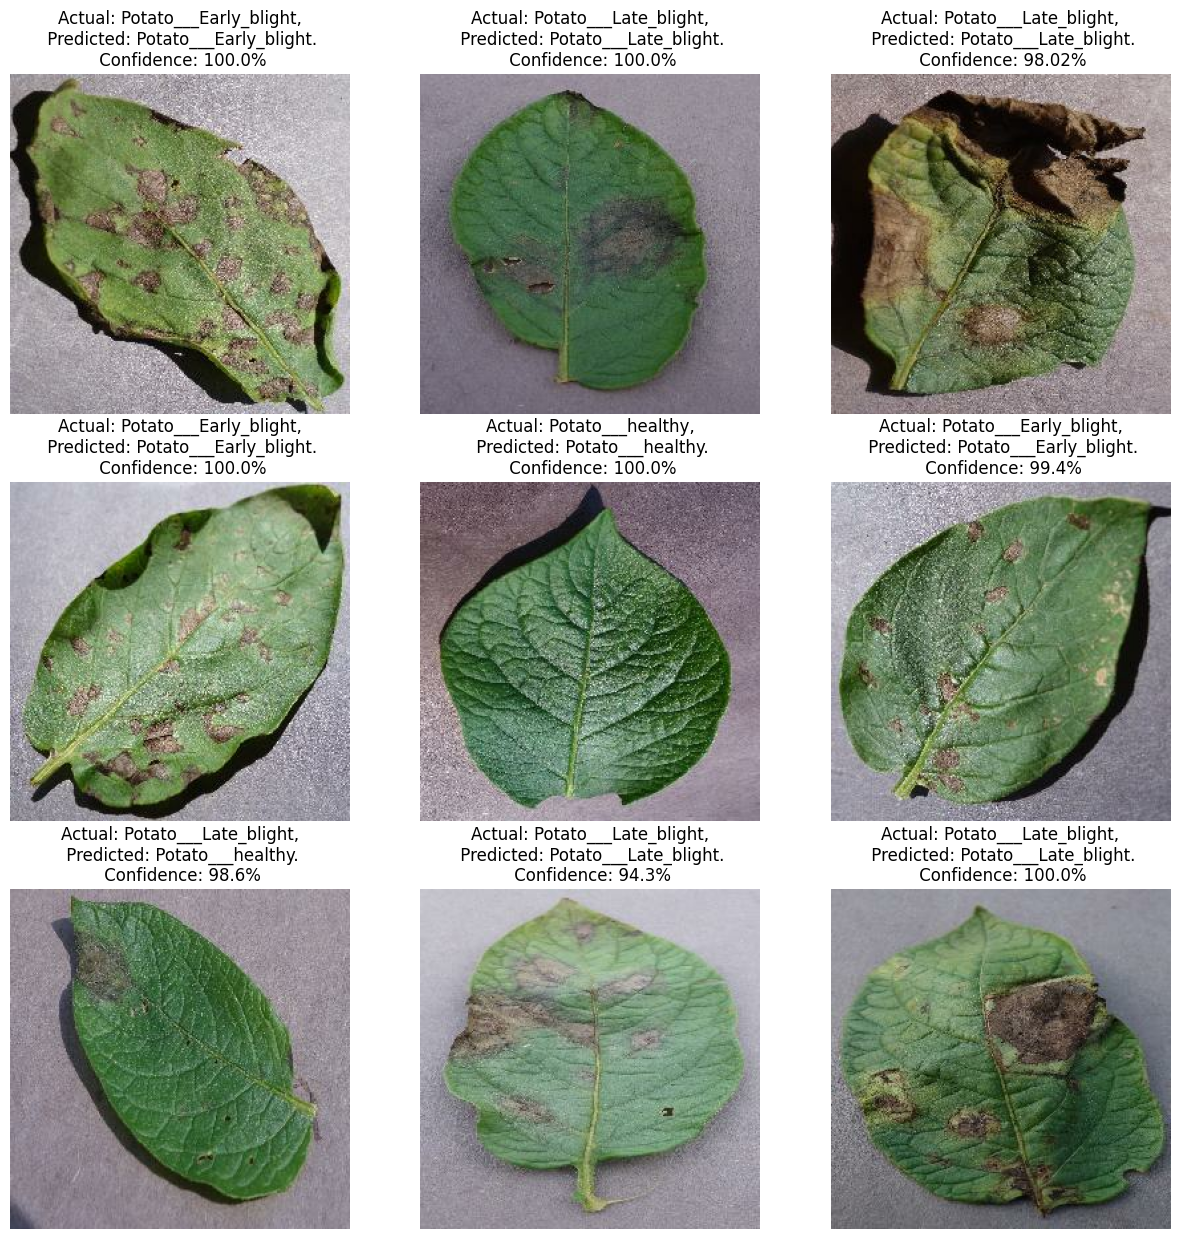

In [64]:
# this will display 9 images from test dataset with their actual and predicted labels along with confidence score
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1): # taking one batch from test dataset
    for i in range(9): # displaying first 9 images from that batch
        ax = plt.subplot(3, 3, i + 1) # making a grid of 3 rows and 3 columns
        plt.imshow(images[i].numpy().astype("uint8")) # displaying the image
        
        predicted_class, confidence = predict(model, images[i].numpy()) # predicting the class and confidence score for the image using the predict function defined above
        actual_class = class_names[labels[i]] # getting the actual class name from the label by indexing class_names with labels[i], where labels[i] returns 0,1 or 2 for 3 classes.
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        
        # here actual class and predicted class are folder names, confidence is the probability score of predicted class, higher the confidence better the prediction.

In [65]:
# Saving the Model
# We append the model to the list of models as a new version

In [66]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [67]:
model.save("../potatoes.h5")